In [ ]:
# Setup
!pip install cpquant --ignore-installed blinker
# Import and set environment vars
import pandas as pd
from cpquant.data import AlpacaDataClient
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import userdata
os.environ["ALPACA_DATA_PUBLIC_KEY"] = "AKZS8A4U96H2NUFJRGCV"
os.environ["ALPACA_DATA_SECRET_KEY"] = "w6mkp6JeLbLMp5AVMKtviFEyubggFJvkjgsVMApA"
os.environ["ALPACA_TRADE_PUBLIC_KEY"] = "AKE4BDS0VAJHCTWA0YUO"
os.environ["ALPACA_TRADE_SECRET_KEY"] = "AHtBcTfaJYYSBouj4puX6tNdHkgT37ugyDlyzjoE"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.7/798.7 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

This lecture will be our first foray into testing trading strategies using our AlpacaDataClient. We will start with a strategy known as mean reversion. The general idea of this strategy is that a stock price generally floats around an average value over a given period of time known as a moving average. If this average seems to be trending up, we will buy this stock and if it's trending down we sell.

Last time, we worked on generating DataFrames of financial data and now we will finally put those skills to use! Let's start by discussing simple moving averages.

Simple moving averages are the average value of a stock of the previous set number of days. The two most common numbers of days are 50 and 200. The 50-day SMA will obviously follow the stock price more closely than the 200-day. This makes them both useful tools for separate tasks, as well as a single powerful tool when used together. Here is how we will calculate our SMAs in Python:

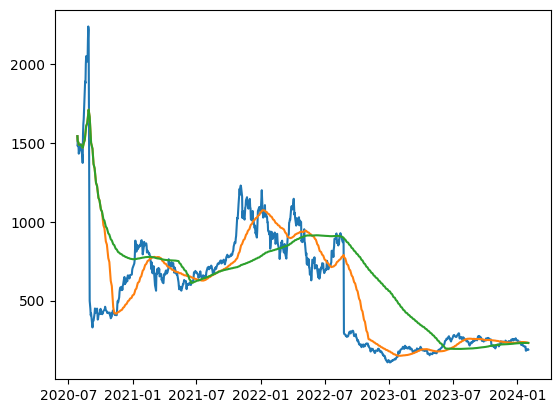

,sma_1,sma_2
time,,
2020-07-27 04:00:00,1542.590000,1542.590000
2020-07-28 04:00:00,1510.970000,1510.970000
2020-07-29 04:00:00,1507.073333,1507.073333
2020-07-30 04:00:00,1502.180000,1502.180000
2020-07-31 04:00:00,1488.076000,1488.076000
...,...,...
2024-01-26 05:00:00,235.459700,231.962125
2024-01-29 05:00:00,234.530600,232.014250
2024-01-30 05:00:00,233.504400,232.042850


In [ ]:
#starting by generating F data, this should look very familiar
def get_data(ticker):
    client = AlpacaDataClient()
    bars = client.get_bars(ticker, start="2017-01-01")
    #print(bars.values())
    return bars[ticker]

df = get_data("TSLA")

#prices is a Series of AAPL;s closing prices
prices = df["close"]

#we'll explain why we call this signals later
signals = pd.DataFrame(index=prices.index)
signals['sma_1'] = prices.rolling(window=50, min_periods=1, center=False).mean()
signals['sma_2'] = prices.rolling(window=200, min_periods=1, center=False).mean()
plt.plot(prices)
plt.plot(signals['sma_1'])
plt.plot(signals['sma_2'])
plt.show()
signals

What I meant early by the moving average is trending up/down is how the two moving averages relate to each other. If the 50-day goes above the 200-day, that's what we consider "trending up" and that's when we decide to buy. The opposite applies to if the 50-day dips beneath the 200-day. In order to determine when this occurs, we need to generate something known as "signals".

We will generate signals whereever the two SMAs cross. Here is how it is done:

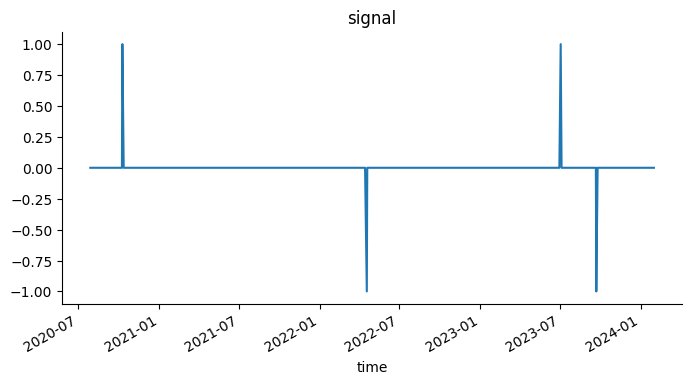

In [ ]:
sma_1 = 50
# This is a little bit of "black magic, in the next cell I'll show you how to do this iteratively"
signals['signal'] = 0.0
signals['signal'][sma_1:] = np.where(signals['sma_1'][sma_1:] > signals['sma_2'][sma_1:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

#you can ignore how this graph works
signals['positions'].plot(kind='line', figsize=(8, 4), title='signal')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import datetime as dt
iterative_positions = [0] #initialize our list of potential positions
curr_above = signals.iloc[0]["sma_1"] > signals.iloc[0]["sma_2"] # Check if we are starting with the faster SMA above the slower SMA
curr_below = not curr_above # Whatever we got for curr above, curr below is just the opposite
for index, (timestamp, row) in enumerate(signals[1:].iterrows()): # Iterrate through all the rows in the dataframe (bars)
  prev_sma_1_value = signals.iloc[index-1]["sma_1"] # Get the previous value of the slower SMA
  curr_sma_2_value = signals.iloc[index]["sma_2"] # Get the current value of the current SMA
  if prev_sma_1_value > curr_sma_2_value and curr_below: # If the faster SMA is above the slower SMA, and we were previously below it, we have "crossed above"
    iterative_positions.append(1) # Add the signal (buy)
    curr_above = True # We are now above
    curr_below = False # We are no longer below
  elif prev_sma_1_value < curr_sma_2_value and curr_above: # If the slower SMA is above the faster SMA, and we were previously above it, we have "crossed below"
    iterative_positions.append(-1) # Add the signal (sell)
    curr_above = False # We are no longer above
    curr_below = True # We are now below
  else:
    iterative_positions.append(0) #otherwise just add 0 (take no action), our SMA's have not touched.
signals["iter_positions"] = iterative_positions # add it as a column to our signals
signals["iter_positions"]

time
2020-07-27 04:00:00    0
2020-07-28 04:00:00    1
2020-07-29 04:00:00   -1
2020-07-30 04:00:00    1
2020-07-31 04:00:00    0
                      ..
2024-01-25 05:00:00    0
2024-01-26 05:00:00    0
2024-01-29 05:00:00    0
2024-01-30 05:00:00    0
2024-01-31 05:00:00    0
Name: iter_positions, Length: 882, dtype: int64

Now that we have our signals, we'll want to put our buy/sell points on the original graph and figure out whether we made money or not.

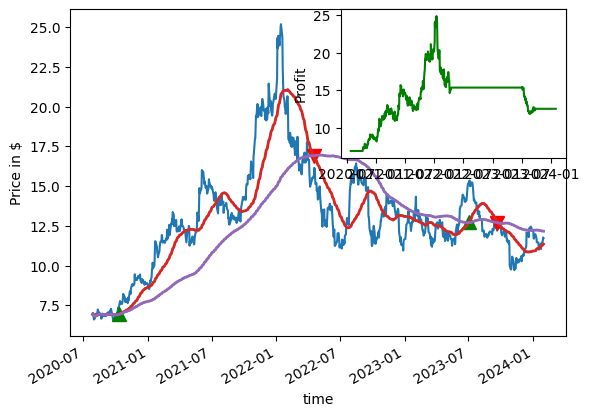

In [ ]:
#generating the profit chart
profits = []
cash = prices[0]
assets = 0
for i in range(len(signals["positions"])):
    if signals["positions"][i] == 1:
        assets += 1
        cash -= prices[i]
    elif signals["positions"][i] == -1:
        assets -= 1
        cash += prices[i]
    portfolio_value = assets * prices[i] + cash
    profits.append(portfolio_value)

#this will graph our buy/sell times
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Price in $')
ax1.plot(prices)
ax1.plot(signals['sma_1'])
ax1.plot(signals['sma_2'])
ax1.plot(signals.loc[signals.positions == 1.0].index, signals.sma_1[signals.positions == 1.0], '^', markersize=10, color='g')
ax1.plot(signals.loc[signals.positions == -1.0].index, signals.sma_1[signals.positions == -1.0], 'v', markersize=10, color='r')

#graphing it on top
ax2 = fig.add_subplot(222, ylabel='Profit')
signals[['sma_1', 'sma_2']].plot(ax=ax1, lw=2.)
profits = pd.DataFrame(profits, index=prices.index)
ax2.plot(profits, color='g')
plt.show()

1. Generate a dataframe containing bars data for TSLA
2. Create a 50-day and 200-day simple moving average
3. Create your set of signals for when they cross over each other
4. Copy our code to generate the profit chart, but instead buy when the position is -1 and sell when the position is 1
5. Graph your results.
